## Positivity estimation

We got from the [RIVM]("https://github.com/mzelst/covid-19/raw/master/data-rivm/tests/rivm_daily_2023-04-04.csv.gz") data the daily estimates of new positive tests. There are many municipalities, and the time goes from 2020-06-01 to 2023-03-17.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma # for the negativisation curve
from comma.model import Model
from comma.hypothesis import Hypothesis

#### Useful functions

In [20]:
def get_negative_individuals(population):
    """
    Get the indices of individuals who are marked as negative (0) in the population.

    Each individual in the population list is represented as a tuple, 
    where the second element of the tuple indicates the individual's status (0 = negative, 1 = positive).

    Args:
    population (list): A list of tuples, where each tuple represents an individual 
                       and the second element of the tuple represents the individual's status.

    Returns:
    idxs: A list of indices corresponding to negative individuals in the population list.
    """
    
    idxs = [i for i, x in enumerate(population) if x[1]==0]
    return idxs

def get_positive_individuals(population):
    """
    Get the indices of individuals who are marked as positive (1) in the population.

    Each individual in the population list is represented as a tuple, 
    where the second element of the tuple indicates the individual's status (0 for negative, 1 for positive).

    Args:
    population (list): A list of tuples, where each tuple represents an individual 
                       and the second element of the tuple represents the individual's status.

    Returns:
    idxs: A list of indices corresponding to positive individuals in the population list.
    """
    
    idxs = [i for i, x in enumerate(population) if x[1]==1]
    return idxs

def update_covid_counter(population):
    """
    Update the counter for positive individuals in a population.

    The function finds positive individuals and increments a counter, 
    which is the third element of the population tuple.

    Args:
    population (list): A list of lists, each representing an individual. 
                       The second element is the status, the third is a counter.

    Returns:
    population (list): The updated population list with the counter incremented for positive individuals.
    """
    
    positives = get_positive_individuals(population)
    for i in positives:
        population[i][2]+=1
    return population
    

def is_recovered(n_days):
    """
    Determine if an individual is recovered based on the number of days since testing positive.

    The function uses a gamma cumulative distribution function with shape parameter 5 and scale parameter 3 
    to model the probability of recovery. This can be of course changed based on the literature.
    Note that if `n_days` is equal or lower than 5, then the probability of recovering is always 0, as per Astrid's suggestion.

    Args:
    n_days (int): The number of days since the individual tested positive.

    Returns:
    recovered (bool): True if the individual is considered recovered, False otherwise.
    """
    
    if n_days <= 5:
        recovered = False
    else:
        recovery_prob = gamma.cdf(n_days, a=5, scale=3)
        recovered = np.random.uniform() <= recovery_prob
    
    return recovered

def get_recovered_individuals(population):
    """
    Get the indices of individuals who are recovered from COVID-19 in a population.

    The function finds positive individuals and checks if they are considered recovered 
    based on the number of days since they tested positive.

    Args:
    population (list): A list of tuples, each representing an individual. 
                       The second element is the status, the third is the number of days since testing positive.

    Returns:
    recovered (list): A list of indices corresponding to recovered individuals in the population list.
    """

    positives = get_positive_individuals(population)
    recovered = []
    for i in positives:
        days_positive = population[i][2]
        
        if is_recovered(days_positive):
            recovered.append(i)
    
    return recovered
    
def count_infected(population):
    """
    Count the number of infected individuals in a population.

    The function finds positive individuals and counts them.

    Args:
    population (list): A list of tuples, each representing an individual. 
                       The second element of the tuple represents the individual's status.

    Returns:
    int: The number of positive individuals in the population list.
    """
    return len(get_positive_individuals(population))

In [10]:
def get_covid_data(time_period, location):
    """
    Download and filter COVID-19 test data.

    Args:
    time_period (tuple): Start and end date ('YYYY-MM-DD', 'YYYY-MM-DD').
    location (str): Security region name.

    Returns:
    pandas.DataFrame: Filtered data.
    """
    
    furl_tests = "https://github.com/mzelst/covid-19/raw/master/data-rivm/tests/rivm_daily_2023-04-04.csv.gz"

    df_tests = pd.read_csv(furl_tests, compression="gzip", header=0, sep=",", quotechar='"')
    df_tests['Date_of_statistics'] = pd.to_datetime(df_tests['Date_of_statistics'])
    
    mask = (df_tests['Date_of_statistics'] >= time_period[0]) & (df_tests['Date_of_statistics'] <= time_period[1]) & (df_tests['Security_region_name'] == location)
    df_filtered = df_tests.loc[mask].reset_index(drop=True)
    
    return df_filtered


In [3]:
def get_positive_cases(time_period, location):
    """
    Get an array of daily positive COVID-19 cases for a specific time period and location.

    Args:
    time_period (tuple): Start and end date ('YYYY-MM-DD', 'YYYY-MM-DD').
    location (str): Security region name.

    Returns:
    pandas.Series: Daily positive cases.
    """
    
    df_filtered = get_covid_data(time_period, location)
    daily_positive_cases = df_filtered['Tested_positive']
    
    return daily_positive_cases

## Select an example period

I want to focus on a period whereby there are always new positive cases, so from january 2022 to march 2022. The reason for this is that I need new cases every day to test that the functions work.

In [9]:
hypothesis = Hypothesis()
df_groningen = hypothesis.get_covid_data(('2022-01-01', '2022-03-15'), 'Groningen')

In [10]:
df_groningen.head()

,Version,Date_of_report,Date_of_statistics,Security_region_code,Security_region_name,Tested_with_result,Tested_positive
0,2,2022-01-03T09:00:00Z,2022-01-01,VR01,Groningen,976,378
1,2,2022-01-04T09:00:00Z,2022-01-01,VR01,Groningen,976,378
2,2,2022-01-04T09:00:00Z,2022-01-02,VR01,Groningen,1624,555
3,2,2022-01-05T09:00:00Z,2022-01-01,VR01,Groningen,977,378
4,2,2022-01-05T09:00:00Z,2022-01-02,VR01,Groningen,1624,555


In [29]:
sorted_df = df_groningen.sort_values(by="Date_of_report", ascending=False)
agg_df = sorted_df.groupby('Date_of_statistics').first().reset_index()

In [30]:
agg_df.head()

,Date_of_statistics,Version,Date_of_report,Security_region_code,Security_region_name,Tested_with_result,Tested_positive
0,2022-01-01,2,2022-03-15T09:00:00Z,VR01,Groningen,975,378
1,2022-01-02,2,2022-03-15T09:00:00Z,VR01,Groningen,1624,555
2,2022-01-03,2,2022-03-15T09:00:00Z,VR01,Groningen,2435,846
3,2022-01-04,2,2022-03-15T09:00:00Z,VR01,Groningen,2925,998
4,2022-01-05,2,2022-03-15T09:00:00Z,VR01,Groningen,3231,845


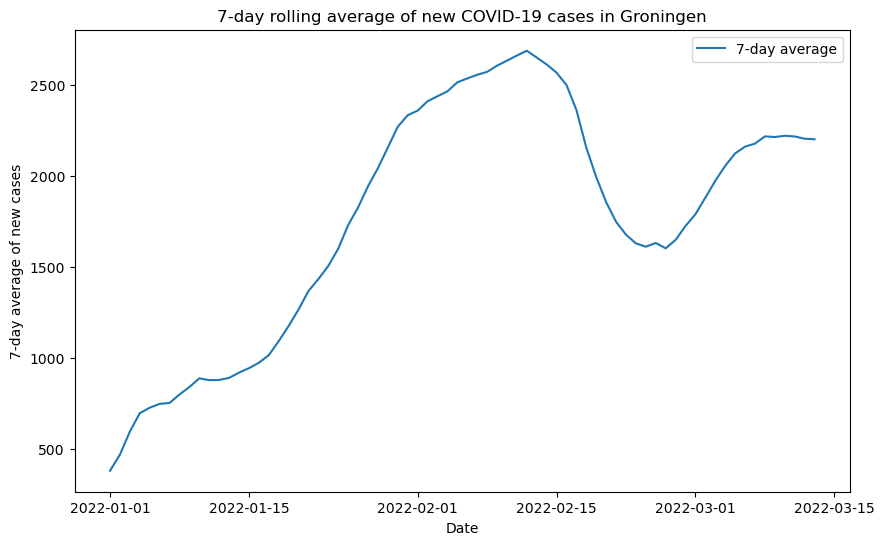

In [31]:
# Calculate seven-day rolling average
agg_df['7_day_avg'] = agg_df['Tested_positive'].rolling(window=7, min_periods=1).mean()

# Create line plot
plt.figure(figsize=(10,6))
plt.plot(agg_df['Date_of_statistics'], agg_df['7_day_avg'], label='7-day average')
plt.xlabel('Date')
plt.ylabel('7-day average of new cases')
plt.title('7-day rolling average of new COVID-19 cases in Groningen')
plt.legend()
plt.show()

This plot is in line with what I can gather from the [Financial Times](https://ig.ft.com/coronavirus-chart/?areas=nld&areasRegional=usny&areasRegional=usnm&areasRegional=uspr&areasRegional=usaz&areasRegional=usfl&areasRegional=usnd&cumulative=0&logScale=0&per100K=0&startDate=2021-11-01&values=cases). So I think we can trust these data -- even though the absolute numbers do not necessarily match in magnitude, the shape of infection growth is identical.

In [11]:
# raw number of new positive cases per day
hypothesis = Hypothesis()
new_cases = hypothesis.get_positive_cases(('2022-01-01', '2022-03-02'), 'Groningen')

In [4]:
new_cases

0      378
1      555
2      846
3      998
4      845
      ... 
82    1329
83    1097
84     865
85     865
86    1227
Name: Tested_positive, Length: 87, dtype: int64

In [14]:
size = 10000 # this is our size of the population
steps = range(len(new_cases)) # these are our steps in the simulation
population_size = 200336 # this is the real number of individuals living in groningen (from google)

### Step 1: compute new positives in our population as `new_cases_sim` = (n/N)*M

We compute the number of new positives in day _i_ for our simulated population as `new_cases_sim` = (n/N)*M where N is the size of the real population, M is the size of the simulated population, n is the number of new positives reported on RIVM for that day. This equals to these steps below:

In [8]:
new_cases_sim = (new_cases * size) / population_size
new_cases_sim = new_cases_sim.astype("int")

In [25]:
type(new_cases_sim)

pandas.core.series.Series

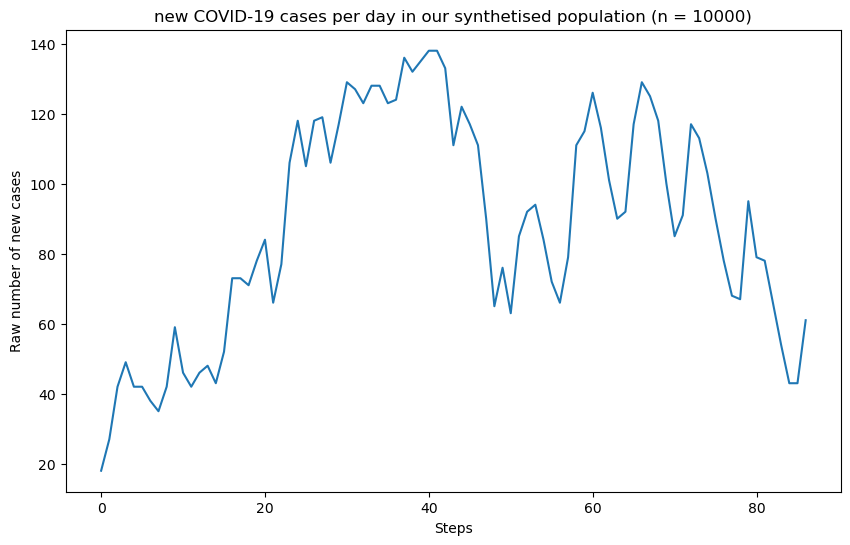

In [10]:
plt.figure(figsize=(10,6))
plt.plot(steps, new_cases_sim)
plt.xlabel('Steps')
plt.ylabel('Raw number of new cases')
plt.title('new COVID-19 cases per day in our synthetised population (n = 10000)')
plt.savefig('new_covid_cases.png')
plt.show()

OK -- we know now how many people per day will became positive in those 90 days, we can use this number now to select from our population the negative people, and assign them a positivity. 

## Step 2: Define how long individuals in the simulation will stay positive

The decourse must have a distribution with a peak ~ 10 days, and have a very long tail. Given these premises a good approximation is the gamma distribution. Of course this assumption has to be double checked with the literature to see if it makes sense, since it's made on my memories of the covid-19 quarantine rules. I remember that the time it took to people to return negative around 7+/- 3 days.

To find the optimal parameters for the gamma distribution that would emulate that behavior, I tried some values and went for a = 5 and scale = 3. 

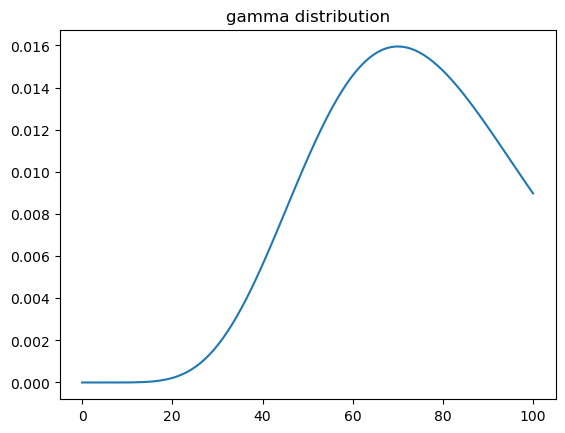

In [19]:
from scipy.stats import gamma

#define x-axis values
x = np.linspace (0, 100, 100) 

#calculate pdf of Gamma distribution for each x-value
y = gamma.pdf(x, a=9, scale=70 / (9 - 1))


plt.plot(x, y)
plt.title('gamma distribution')
plt.savefig("gamma.png")
plt.show()

### Step 3: For each step, select the relative number of new infected individuals, make them positive, count for how long they will stay positive, then flag them as recovered

OK the code below does this:

1. generates the individuals
2. creates population, which is a list of lists, each representing an individual. The second element is the covid status, the third is the positivity counter.

3. At every step:

    3.1 We take new infected from `new_cases_sim` computed above
    
    3.2 We extract the individuals who are negative (0)
    
    3.3 From this pool, we select randomly the number of new infected
    
    3.4 For each one of those selected, we flag them as positive (1)
    
    3.5 We update the covid counter of the population which counts how many steps have passed from the first positive day
    
    3.6 We get the individuals who have recovered (i.e., they switched from positive to negative)
    
    3.7 Recovered individuals are flagged as negative (0) and their counter re-set to 0. They can be infected again.
    
    3.8 Keep track of how many people have been infected at each day by computing the fraction of infected people over the total 
    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma # for the negativisation curve
from comma.model import Model
from comma.hypothesis import Hypothesis
from datetime import datetime, timedelta
from comma.individual import Individual
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
size = 500 # this is our size of the population
steps = 16 # these are our steps in the simulation

# generate the population
model = Model()
model.setup(size, '../parameters/')


Populating individuals: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2207.53i/s]


In [3]:
n = steps // 4
lockdown_pattern = ["absent"]*n + ["medium"]*n + ["hard"]*n + ["easy"]*n

In [4]:
len(lockdown_pattern)

16

In [5]:
model.run(steps=steps, lockdown_policy=lockdown_pattern, out_path="simulation_results.csv")

/Users/evaviviani/github/comma/comma/hypothesis.py:312: UserWarning: Given sim_size=1, real_size=20336, and max daily cases=239,the scaling might result in all zeros.
  warnings.warn(message)
Running simulation: 100%|█████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 4228.40it/s]


In [6]:
data = pd.read_csv('simulation_results.csv', delimiter=";", decimal=",")

In [7]:
data

,step_id,lockdown,agent_id,delta_mental_health,cumulative_mental_health,covid_status,days_since_first_infection
0,0,absent,0,0.00,0.000000,0,NaN
1,1,absent,0,-1.24,-1.241986,0,NaN
2,2,absent,0,0.00,-1.243496,0,NaN
3,3,absent,0,-1.24,-2.485537,0,NaN
4,4,medium,0,-3.84,-6.327633,0,NaN
5,5,medium,0,-5.90,-12.230890,0,NaN
6,6,medium,0,-6.90,-19.133552,0,NaN
7,7,medium,0,-7.09,-26.225097,0,NaN
8,8,hard,0,-0.73,-26.956782,0,NaN
9,9,hard,0,-0.14,-27.099114,0,NaN


In [17]:
data['covid_status'].unique()

array([0, 1])

In [18]:
data[data['covid_status']==1]['agent_id'].nunique()

638

In [9]:
agg_df = data.groupby(['step_id', 'lockdown'])['cumulative_mental_health'].mean().reset_index()
agg_df['label'] = 'average mental health'

few_points = data[data['agent_id'] <= 3]
other_points = data[data['agent_id'] > 3]

max_step_ids = data.groupby('lockdown')['step_id'].max().reset_index()


In [10]:
# Create a dictionary with a unique color for each agent_id
colors = {}
unique_agents = data['agent_id'].unique()
for agent in unique_agents:
    if agent <= 3:
        colors[agent] = {0: "#386cb0", 1: "#fdb462", 2: "#7fc97f", 3: "darkred"}[agent]
    else:
        colors[agent] = "gainsboro"

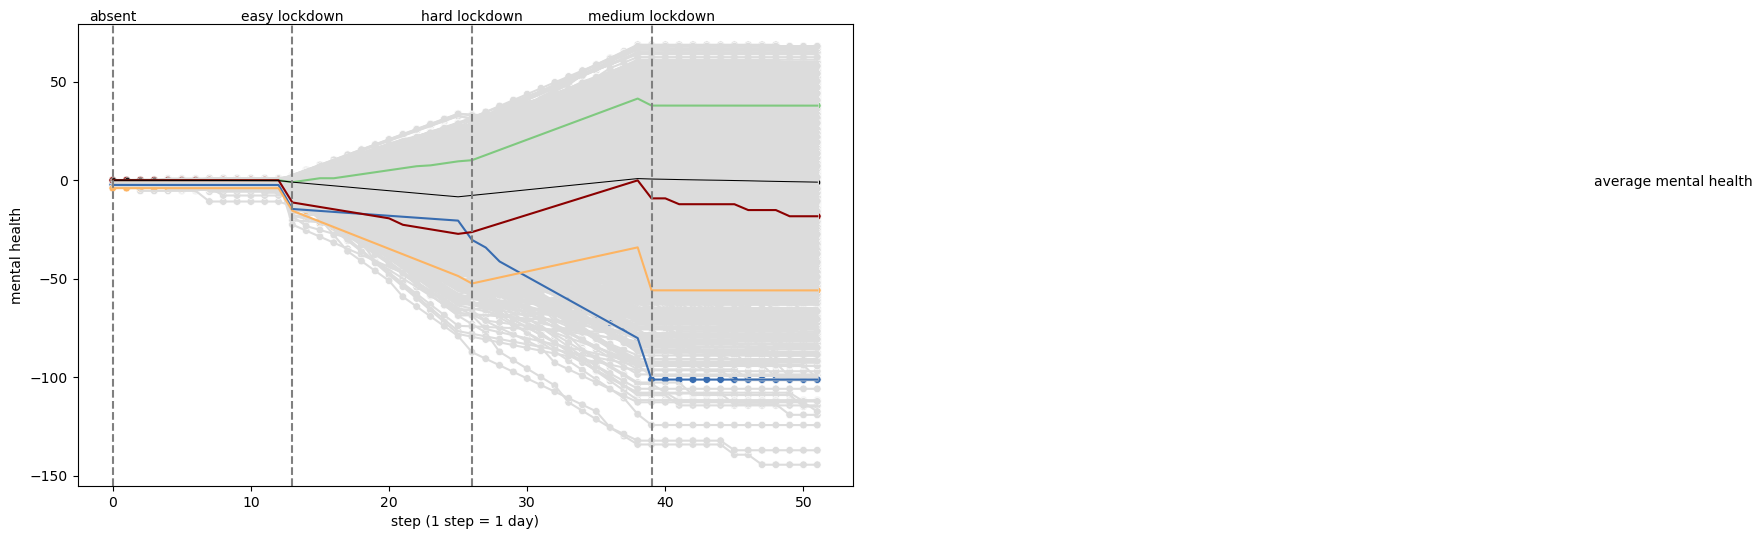

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

# other_points
sns.lineplot(data=other_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, legend=False)
sns.scatterplot(data=other_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, s=30, legend=False)

# few_points
sns.lineplot(data=few_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, ax=ax)
sns.scatterplot(data=few_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, s=30, ax=ax)

# agg_df
sns.lineplot(data=agg_df, x='step_id', y='cumulative_mental_health', color='black', ax=ax, size=2)
sns.scatterplot(data=agg_df, x='step_id', y='cumulative_mental_health', color='black', s=20, ax=ax)

vector = [i * n for i in range(4)]

# add lockdown labels and dotted lines
for x_val, label in zip(vector, ['absent', 'easy lockdown', 'hard lockdown', 'medium lockdown']):
    ax.axvline(x=x_val, linestyle='--', color='gray')
    ax.text(x=x_val, y=ax.get_ylim()[1], s=label, va='bottom', ha='center')

avg_mh_text_y = agg_df[agg_df['step_id'] == agg_df['step_id'].max()]['cumulative_mental_health'].values[0]
ax.text(113, avg_mh_text_y, 'average mental health', va='center', ha='center', color='black')

ax.set_xlabel('step (1 step = 1 day)')
ax.set_ylabel('mental health')
ax.get_legend().remove()

plt.show()


In [40]:
positives

0    127
1     72
2      0
3    128
4    128
dtype: int64

In [25]:
(positives * real_pop_size) / len(model.agents)

0    845.0
1    852.0
2    778.0
3    704.0
4    704.0
dtype: float64

In [27]:
len(model.agents)
real_pop_size

25

In [21]:
real_pop_size=25
Hypothesis.scale_cases_to_population(positives, real_pop_size, len(model.agents))

0    845
1    852
2    778
3    704
4    704
dtype: int64

In [17]:
max(positives) * 1000 < real_pop_size

False

In [18]:
positives.max()

999

In [21]:
time_period

('2022-01-01', '2022-01-11')

In [13]:
datetime.strptime(, '%Y-%m-%d')

ValueError: unconverted data remains:  00:00:00

In [8]:
model.agents[0].days_since_positive

nan

In [9]:
model.cumulative_status.items()

dict_items([])

In [29]:
population = [[i,0,0] for i in model.agents] 
population[0]

[<comma.individual.Individual at 0x2a70d8a90>, 0, 0]

In [30]:
# get negative individuals
[i for i, x in enumerate(population) if x[1]==0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# individual, positive/not-positive, n-day from first day of positivity

frac_infected = []

for step in steps:
    n_infected = new_cases_sim[step]
    
    negative_idxs_population = get_negative_individuals(population)
    new_infected_idxs = np.random.choice(negative_idxs_population, n_infected, replace=False)
    
    for i in new_infected_idxs:
        population[i][1] = 1
    
    #updates counter of positive days for positive people
    population = update_covid_counter(population)
    
    #recovery
    recovered_idxs = get_recovered_individuals(population)
    for i in recovered_idxs:
        population[i][1] = 0
        population[i][2] = 0 #for now people can re-infect
        
    frac_infected.append(count_infected(population)/size)  
        

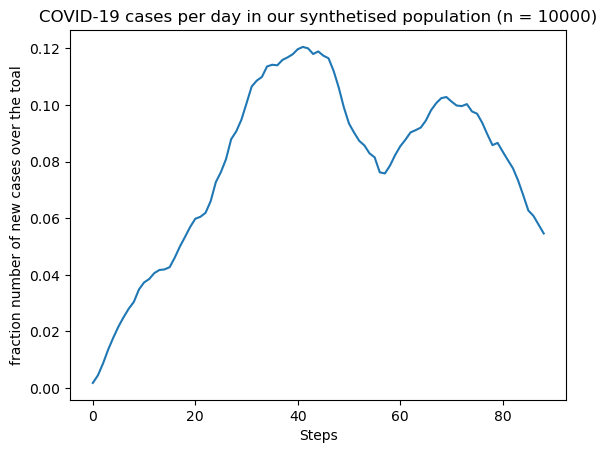

In [28]:
plt.plot(frac_infected)
plt.xlabel('Steps')
plt.ylabel('fraction number of new cases over the toal')
plt.title('COVID-19 cases per day in our synthetised population (n = 10000)')
plt.show()

In [12]:
time_period = ('2022-01-01', '2022-03-02')
location = 'Groningen'

hypothesis = Hypothesis()
positives = hypothesis.get_positive_cases(time_period, location)

In [21]:
positives[0]

378

In [23]:
real_pop_size = 200336
new_cases = hypothesis.scale_cases_to_population(positives, real_pop_size, len(model.agents))

In [32]:
type(new_cases)

pandas.core.series.Series